In [1]:
import numpy as np
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from rectification_utils import *
import open3d as o3d
import laspy
import lazrs
import laszip

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])

extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

(3, 35549)
Directory to store grids already exists: data/generated_grids


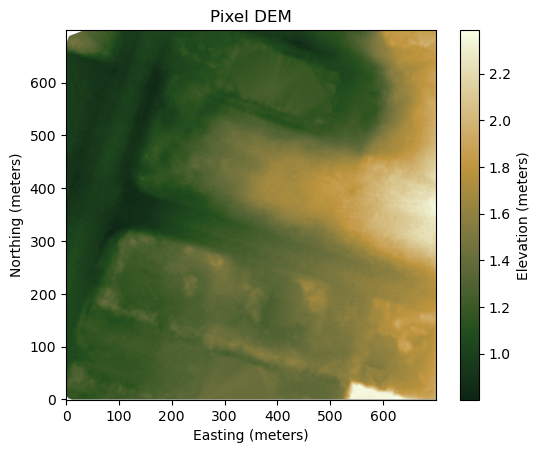

In [3]:
file_path = '/home/rmccune/depth_mapping/data/lidar/Job1051007_34077_04_88.laz'

las = laspy.read(file_path)

pts_mask = las.classification == 2 # land classification (1 is unclassified points)

xyz_t = np.vstack([las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]])

building_xyz_m = xyz_t * 0.3048 

point_cloud_df = pd.DataFrame(building_xyz_m.T, columns=['x', 'y', 'z'])

max_x_extent = 712230
min_x_extent = 712160
max_y_extent = 33170
min_y_extent = 33100

# Filter the DataFrame
filtered_df = point_cloud_df[
    (point_cloud_df['x'] >= min_x_extent) & (point_cloud_df['x'] <= max_x_extent) &
    (point_cloud_df['y'] >= min_y_extent) & (point_cloud_df['y'] <= max_y_extent)
]

x = filtered_df['x'].values
y = filtered_df['y'].values
z = filtered_df['z'].values

resolution = 0.10 # meters

pts_array = np.array([x, y, z])

print(pts_array.shape)

grid_dir = 'data/generated_grids'
grid_x, grid_y, grid_z = gen_grid(min_x_extent, max_x_extent, min_y_extent, max_y_extent, resolution, pts_array, dir=grid_dir)

grid_x = grid_x.T
grid_y = grid_y.T
grid_z = grid_z.T

# Get the topo colormap from cmocean
cmap = cmocean.cm.topo

# Truncate the colormap to get only the above-land portion
# Assuming "above land" is the upper half of the colormap
above_land_cmap = LinearSegmentedColormap.from_list(
    'above_land_cmap', cmap(np.linspace(0.5, 1, 256))
)

plt.imshow(grid_z, origin='lower', cmap=above_land_cmap)
plt.colorbar(label='Elevation (meters)')
plt.title('Pixel DEM')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

# Save the figure before showing it
# plt.savefig('/home/rmccune/depth_mapping/plots/pixel_DEM_1cm_res_CB_03.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [4]:
from rectifier import ImageRectifier

In [5]:
rectifier = ImageRectifier(intrinsics, extrinsics, grid_x, grid_y, grid_z)

AttributeError: 'ImageRectifier' object has no attribute 'grid_shape'

In [6]:
image_numpy = rectifier.merge_rectify('CAM_CB_03_20231008174225.jpg')

/home/rmccune/depth_mapping/image_processing/rectifier.py:325: RuntimeWarning: invalid value encountered in cast
  Ud = Ud.astype(int)
/home/rmccune/depth_mapping/image_processing/rectifier.py:326: RuntimeWarning: invalid value encountered in cast
  Vd = Vd.astype(int)
/home/rmccune/depth_mapping/image_processing/rectifier.py:334: RuntimeWarning: invalid value encountered in cast
  return np.array(ir, dtype=np.uint8)


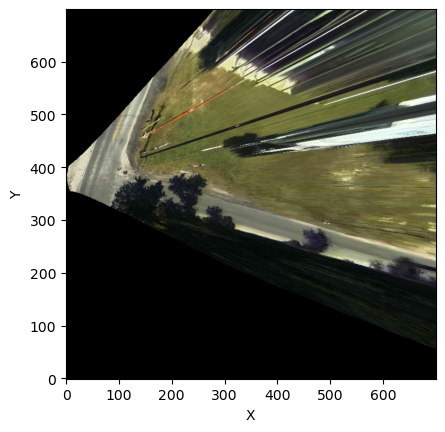

In [7]:
plt.imshow(image_numpy)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [8]:
rectifier = ImageRectifier(intrinsics, extrinsics, grid_x, grid_y, grid_z, use_gpu=True)

In [9]:
image_cupy = rectifier.merge_rectify('CAM_CB_03_20231008174225.jpg')

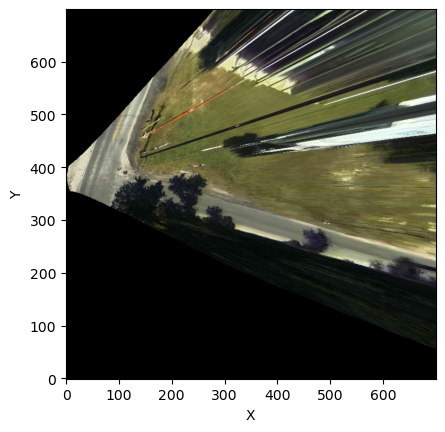

In [11]:
plt.imshow(image_cupy.get())
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()